# Query Biothings Explorer's TRAPI endpoint for DrugMechDB concepts

In [1]:
# Builtin
from pathlib import Path
from itertools import chain
from collections import defaultdict

# PIP
import demjson
import requests
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

# Github
from data_tools.plotting import venn2_pretty as venn2

/home/mmayers/sft/miniconda3/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
this_name = '3_querying_bte_trapi'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

data_dir = Path('../0_data/external').resolve()

In [3]:
ind = nx.read_yaml(data_dir.joinpath('indication_paths.yaml'))

dmdb_nodes = defaultdict(list)
for p in ind:
    for n in p['nodes']:
        for k in ['id', 'name', 'label']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_nodes[k].append(n[k].replace('\ufeff', ''))
dmdb_nodes = pd.DataFrame(dmdb_nodes)

## Compare metanodes in Biothings Explorer TRAPI to DMDB

In [4]:
dmdb_mn = set(dmdb_nodes['label'].unique())

In [5]:
r = requests.get("https://api.bte.ncats.io/v1/predicates")

metagraph = r.json()
bte_mn =  set([k.split(':')[-1] for k in metagraph.keys()])

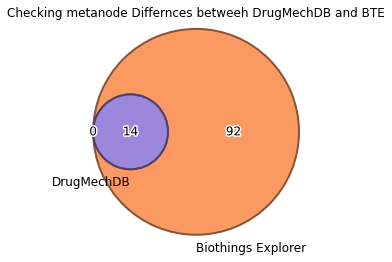

In [6]:
venn2([dmdb_mn, bte_mn], ('DrugMechDB', 'Biothings Explorer'))
plt.title('Checking metanode Differnces betweeh DrugMechDB and BTE');

A perfect Subset

In [7]:
def process_bte_result(result, hops=1):
    out = defaultdict(list)
    for res in result.json()['message']['results']:
        out['n0'].append(res['node_bindings']['n0'][0]['id'])
        for i in range(1, hops+1):
            out['e{0}{1}'.format(i-1, i)].append(res['edge_bindings']['e{0}{1}'.format(i-1, i)][0]['id'].split('-')[1])
            out['n{}'.format(i)].append(res['node_bindings']['n{}'.format(i)][0]['id'])
    return pd.DataFrame(out)

In [8]:
# Taken from https://github.com/kevinxin90/biomedical_id_resolver.js/blob/master/src/config.ts
text = """
{
  Gene: {
    id_ranks: ['NCBIGENE', 'ENSEMBL', 'HGNC', 'SYMBOL', 'OMIM', 'UniProtKB', 'UMLS', 'MGI', 'name'],
    semantic: 'Gene',
    api_name: 'mygene.info',
    url: 'https://mygene.info/v3/query',
    mapping: {
      NCBIGENE: ['entrezgene'],
      name: ['name'],
      SYMBOL: ['symbol'],
      UMLS: ['umls.cui', 'umls.protein_cui'],
      HGNC: ['HGNC'],
      UniProtKB: ['uniprot.Swiss-Prot'],
      ENSEMBL: ['ensembl.gene'],
      OMIM: ['MIM'],
      MGI: ['MGI'],
    },
    additional_attributes_mapping: {
      interpro: ['interpro.desc'],
      type_of_gene: ['type_of_gene'],
    },
  },
  Protein: {
    id_ranks: ['UniProtKB', 'ENSEMBL', 'SYMBOL', 'UMLS', 'name'],
    semantic: 'Protein',
    api_name: 'mygene.info',
    url: 'https://mygene.info/v3/query',
    mapping: {
      name: ['name'],
      SYMBOL: ['symbol'],
      UMLS: ['umls.cui', 'umls.protein_cui'],
      UniProtKB: ['uniprot.Swiss-Prot'],
      ENSEMBL: ['ensembl.protein'],
    },
    additional_attributes_mapping: {
      interpro: ['interpro.desc']
    },
  },
  SequenceVariant: {
    id_ranks: ['HGVS', 'DBSNP', 'MYVARIANT_HG19', 'CLINVAR'],
    api_name: 'myvariant.info',
    semantic: 'SequenceVariant',
    url: 'https://myvariant.info/v1/query',
    mapping: {
      MYVARIANT_HG19: ['_id'],
      DBSNP: ['dbsnp.rsid', 'clinvar.rsid', 'dbnsfp.rsid'],
      HGVS: ['clinvar.hgvs.genomic', 'clinvar.hgvs.protein', 'clinvar.hgvs.coding'],
      ClINVAR: ['clinvar.rcv.accession'],
    },
    additional_attributes_mapping: {
      cadd_consequence: ['cadd.consequence'],
      cadd_variant_type: ['cadd.type'],
      dbsnp_variant_type: ['dbsnp.vartype'],
      clinvar_clinical_significance: ['clinvar.rcv.clinical_significance'],
      sift_category: ['cadd.sift.cat'],
    },
  },
  ChemicalSubstance: {
    id_ranks: [
      'CHEBI',
      'CHEMBL.COMPOUND',
      'DRUGBANK',
      'PUBCHEM.COMPOUND',
      'MESH',
      'INCHI',
      'INCHIKEY',
      'UNII',
      'KEGG',
      'UMLS',
      'name',
    ],
    semantic: 'ChemicalSubstance',
    api_name: 'mychem.info',
    url: 'https://mychem.info/v1/query',
    mapping: {
      'CHEMBL.COMPOUND': ['chembl.molecule_chembl_id', 'drugbank.xrefs.chembl', 'drugcentral.xrefs.chembl_id'],
      DRUGBANK: ['drugcentral.xrefs.drugbank_id', 'pharmgkb.xrefs.drugbank', 'chebi.xrefs.drugbank', 'drugbank.id'],
      'PUBCHEM.COMPOUND': [
        'pubchem.cid',
        'drugbank.xrefs.pubchem.cid',
        'drugcentral.xrefs.pubchem_cid',
        'pharmgkb.xrefs.pubchem.cid',
      ],
      CHEBI: ['chebi.id', 'chembl.chebi_par_id', 'drugbank.xrefs.chebi', 'drugcentral.xrefs.chebi'],
      UMLS: ['drugcentral.xrefs.umlscui', 'pharmgkb.xrefs.umls', 'umls.cui'],
      MESH: ['umls.mesh', 'drugcentral.xrefs.mesh_descriptor_ui', 'ginas.xrefs.MESH', 'pharmgkb.xrefs.mesh'],
      UNII: ['drugcentral.xrefs.unii', 'unii.unii', 'aeolus.unii', 'ginas.unii'],
      INCHIKEY: ['drugbank.inchi_key', 'ginas.inchikey', 'unii.inchikey', 'chebi.inchikey'],
      INCHI: ['drugbank.inchi', 'chebi.inchi', 'chembl.inchi'],
      KEGG: ['drugbank.xrefs.kegg.cid'],
      LINCS: ['unichem.lincs'],
      name: ['chembl.pref_name', 'drugbank.name', 'umls.name', 'ginas.preferred_name', 'pharmgkb.name', 'chebi.name'],
    },
    additional_attributes_mapping: {
      chembl_max_phase: ['chembl.max_phase'],
      chembl_molecule_type: ['chembl.molecule_type'],
      drugbank_drug_category: ['drugbank.categories.category'],
      drugbank_taxonomy_class: ['drugbank.taxonomy.class'],
      drugbank_groups: ['drugbank.groups'],
      drugbank_kingdom: ['drugbank.taxonomy.kingdom'],
      drugbank_superclass: ['drugbank.taxonomy.superclass'],
      contraindications: ['drugcentral.drug_use.contraindication.concept_name'],
      indications: ['drugcentral.drug_use.indication.concept_name'],
      mesh_pharmacology_class: ['drugcentral.pharmacology_class.mesh_pa.description'],
      fda_epc_pharmacology_class: ['drugcentral.pharmacology_class.fda_epc.description'],
    },
  },
  Drug: {
    id_ranks: [
      'CHEBI',
      'CHEMBL.COMPOUND',
      'DRUGBANK',
      'PUBCHEM.COMPOUND',
      'MESH',
      'INCHI',
      'INCHIKEY',
      'UNII',
      'KEGG',
      'UMLS',
      'LINCS',
      'name',
    ],
    semantic: 'ChemicalSubstance',
    api_name: 'mychem.info',
    url: 'https://mychem.info/v1/query',
    mapping: {
      'CHEMBL.COMPOUND': ['chembl.molecule_chembl_id', 'drugbank.xrefs.chembl', 'drugcentral.xrefs.chembl_id'],
      DRUGBANK: ['drugcentral.xrefs.drugbank_id', 'pharmgkb.xrefs.drugbank', 'chebi.xrefs.drugbank', 'drugbank.id'],
      'PUBCHEM.COMPOUND': [
        'pubchem.cid',
        'drugbank.xrefs.pubchem.cid',
        'drugcentral.xrefs.pubchem_cid',
        'pharmgkb.xrefs.pubchem.cid',
      ],
      CHEBI: ['chebi.id', 'chembl.chebi_par_id', 'drugbank.xrefs.chebi', 'drugcentral.xrefs.chebi'],
      UMLS: ['drugcentral.xrefs.umlscui', 'pharmgkb.xrefs.umls', 'umls.cui'],
      MESH: ['umls.mesh', 'drugcentral.xrefs.mesh_descriptor_ui', 'ginas.xrefs.MESH', 'pharmgkb.xrefs.mesh'],
      UNII: ['drugcentral.xrefs.unii', 'unii.unii', 'aeolus.unii', 'ginas.unii'],
      INCHIKEY: ['drugbank.inchi_key', 'ginas.inchikey', 'unii.inchikey', 'chebi.inchikey'],
      INCHI: ['drugbank.inchi', 'chebi.inchi', 'chembl.inchi'],
      KEGG: ['drugbank.xrefs.kegg.cid'],
      name: ['chembl.pref_name', 'drugbank.name', 'umls.name', 'ginas.preferred_name', 'pharmgkb.name', 'chebi.name'],
    },
    additional_attributes_mapping: {
      chembl_max_phase: ['chembl.max_phase'],
      chembl_molecule_type: ['chembl.molecule_type'],
      drugbank_drug_category: ['drugbank.categories.category'],
      drugbank_taxonomy_class: ['drugbank.taxonomy.class'],
      drugbank_groups: ['drugbank.groups'],
      drugbank_kingdom: ['drugbank.taxonomy.kingdom'],
      drugbank_superclass: ['drugbank.taxonomy.superclass'],
      contraindications: ['drugcentral.drug_use.contraindication.concept_name'],
      indications: ['drugcentral.drug_use.indication.concept_name'],
      mesh_pharmacology_class: ['drugcentral.pharmacology_class.mesh_pa.description'],
      fda_epc_pharmacology_class: ['drugcentral.pharmacology_class.fda_epc.description'],
    },
  },
  PhenotypicFeature: {
    id_ranks: ['UMLS', 'SNOMEDCT', 'HP', 'MEDDRA', 'EFO', 'NCIT', 'MESH', 'MP', 'name'],
    semantic: 'PhenotypicFeature',
    api_name: 'HPO API',
    url: 'https://biothings.ncats.io/hpo/query',
    mapping: {
      UMLS: ['xrefs.umls'],
      SNOMEDCT: ['xrefs.snomed_ct'],
      HP: ['_id'],
      MEDDRA: ['xrefs.meddra'],
      EFO: ['xrefs.efo'],
      NCIT: ['xrefs.ncit'],
      MESH: ['xrefs.mesh'],
      MP: ['xrefs.mp'],
      name: ['name'],
    },
  },
  Disease: {
    id_ranks: ['MONDO', 'DOID', 'OMIM', 'ORPHANET', 'EFO', 'UMLS', 'MESH', 'HP', 'GARD', 'name'],
    semantic: 'Disease',
    api_name: 'mydisease.info',
    url: 'https://mydisease.info/v1/query',
    mapping: {
      MONDO: ['mondo.mondo'],
      DOID: ['mondo.xrefs.doid'],
      UMLS: [
        'mondo.xrefs.umls',
        'mondo.xrefs.umls_cui',
        'disgenet.xrefs.umls',
        'umls.umls',
        'disease_ontology.xrefs.umls_cui',
      ],
      name: ['mondo.label', 'disgenet.xrefs.disease_name'],
      MESH: ['mondo.xrefs.mesh', 'disease_ontology.xrefs.mesh', 'ctd.mesh'],
      OMIM: ['mondo.xrefs.omim', 'hpo.omim', 'disgenet.xrefs.omim'],
      EFO: ['mondo.xrefs.efo'],
      ORPHANET: ['hpo.orphanet', 'mondo.xrefs.orphanet'],
      GARD: ['mondo.xrefs.gard', 'disease_ontology.xrefs.gard'],
      HP: ['mondo.xrefs.hp'],
    },
  },
  MolecularActivity: {
    id_ranks: ['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name'],
    semantic: 'MolecularActivity',
    api_name: 'Gene Ontology Molecular Function API',
    url: 'https://biothings.ncats.io/go_mf/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      RHEA: ['xrefs.rhea'],
      KEGG: ['xrefs.kegg_reaction'],
      REACT: ['xrefs.reactome'],
      name: ['name'],
    },
  },
  BiologicalProcess: {
    id_ranks: ['GO', 'MetaCyc', 'REACT', 'KEGG', 'name'],
    semantic: 'BiologicalProcess',
    api_name: 'Gene Ontology Biological Process API',
    url: 'https://biothings.ncats.io/go_bp/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      KEGG: ['xrefs.kegg_pathway'],
      REACT: ['xrefs.reactome'],
      name: ['name'],
    },
  },
  CellularComponent: {
    id_ranks: ['GO', 'MetaCyc', 'RHEA', 'name'],
    semantic: 'CellularComponent',
    api_name: 'Gene Ontology Cellular Component API',
    url: 'https://biothings.ncats.io/go_cc/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      RHEA: ['xrefs.rhea'],
      name: ['name'],
    },
  },
  Pathway: {
    id_ranks: ['REACT', 'KEGG', 'PHARMGKB', 'WIKIPATHWAYS', 'name'],
    semantic: 'Pathway',
    api_name: 'geneset API',
    url: 'https://biothings.ncats.io/geneset/query',
    mapping: {
      REACT: ['reactome'],
      WIKIPATHWAYS: ['wikipathways'],
      KEGG: ['kegg'],
      PHARMGKB: ['pharmgkb'],
      name: ['name'],
    },
    additional_attributes_mapping: {
      num_of_participants: ['num_of_participants'],
    },
  },
  AnatomicalEntity: {
    id_ranks: ['UBERON', 'UMLS', 'MESH', 'NCIT', 'name'],
    semantic: 'AnatomicalEntity',
    api_name: 'UBERON API',
    url: 'https://biothings.ncats.io/uberon/query',
    mapping: {
      UBERON: ['_id'],
      UMLS: ['xrefs.umls'],
      MESH: ['xrefs.mesh'],
      NCIT: ['xrefs.ncit'],
      name: ['name'],
    },
  },
  Cell: {
    id_ranks: ['CL', 'NCIT', 'MESH', 'EFO', 'name'],
    semantic: 'Cell',
    api_name: 'Cell Onotlogy API',
    url: 'https://biothings.ncats.io/cell_ontology/query',
    mapping: {
      CL: ['_id'],
      NCIT: ['xrefs.ncit'],
      MESH: ['xrefs.mesh'],
      EFO: ['xrefs.efo'],
      name: ['name'],
    },
  },
}"""

In [9]:
metadata = demjson.decode(text)
list(metadata.keys())

['Gene',
 'Protein',
 'SequenceVariant',
 'ChemicalSubstance',
 'Drug',
 'PhenotypicFeature',
 'Disease',
 'MolecularActivity',
 'BiologicalProcess',
 'CellularComponent',
 'Pathway',
 'AnatomicalEntity',
 'Cell']

In [10]:
metadata['Drug']['id_ranks']

['CHEBI',
 'CHEMBL.COMPOUND',
 'DRUGBANK',
 'PUBCHEM.COMPOUND',
 'MESH',
 'INCHI',
 'INCHIKEY',
 'UNII',
 'KEGG',
 'UMLS',
 'LINCS',
 'name']

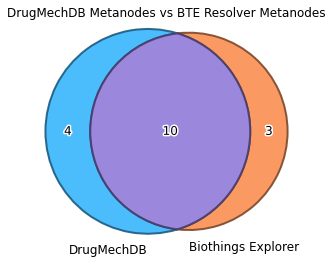

In [11]:
venn2([dmdb_mn, set(metadata.keys())], ('DrugMechDB', 'Biothings Explorer'))
plt.title('DrugMechDB Metanodes vs BTE Resolver Metanodes');

In [12]:
dmdb_mn - set(metadata.keys())

{'GeneFamily',
 'GrossAnatomicalStructure',
 'MacromolecularComplex',
 'OrganismTaxon'}

In [13]:
dmdb_bte_mn_map = {'GrossAnatomicalStructure':'AnatomicalEntity'}

In [14]:
mn_to_quid = {}
for mn in dmdb_mn:
    mn_to_quid[mn] = metadata.get(dmdb_bte_mn_map.get(mn, mn), {}).get('id_ranks', [])

In [15]:
mn_to_quid

{'MolecularActivity': ['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name'],
 'CellularComponent': ['GO', 'MetaCyc', 'RHEA', 'name'],
 'BiologicalProcess': ['GO', 'MetaCyc', 'REACT', 'KEGG', 'name'],
 'Cell': ['CL', 'NCIT', 'MESH', 'EFO', 'name'],
 'MacromolecularComplex': [],
 'OrganismTaxon': [],
 'ChemicalSubstance': ['CHEBI',
  'CHEMBL.COMPOUND',
  'DRUGBANK',
  'PUBCHEM.COMPOUND',
  'MESH',
  'INCHI',
  'INCHIKEY',
  'UNII',
  'KEGG',
  'UMLS',
  'name'],
 'Protein': ['UniProtKB', 'ENSEMBL', 'SYMBOL', 'UMLS', 'name'],
 'GeneFamily': [],
 'PhenotypicFeature': ['UMLS',
  'SNOMEDCT',
  'HP',
  'MEDDRA',
  'EFO',
  'NCIT',
  'MESH',
  'MP',
  'name'],
 'Pathway': ['REACT', 'KEGG', 'PHARMGKB', 'WIKIPATHWAYS', 'name'],
 'Disease': ['MONDO',
  'DOID',
  'OMIM',
  'ORPHANET',
  'EFO',
  'UMLS',
  'MESH',
  'HP',
  'GARD',
  'name'],
 'GrossAnatomicalStructure': ['UBERON', 'UMLS', 'MESH', 'NCIT', 'name'],
 'Drug': ['CHEBI',
  'CHEMBL.COMPOUND',
  'DRUGBANK',
  'PUBCHEM.COMPOUND',
  'MESH',
  

In [16]:
dmdb_nodes['curi'] = dmdb_nodes['id'].apply(lambda s: s.split(':')[0])
mn_to_curi = dmdb_nodes.groupby('label')['curi'].unique().apply(list).to_dict()

In [17]:
def get_types_for_curi(curi):
    out = []
    for k, v in metadata.items():
        if curi in v['id_ranks']:
            out.append(k)
    return out

In [18]:
get_types_for_curi('MESH')

['ChemicalSubstance',
 'Drug',
 'PhenotypicFeature',
 'Disease',
 'AnatomicalEntity',
 'Cell']

In [19]:
for mn in mn_to_curi.keys():
    print(mn, ':', mn_to_curi[mn])
    print(mn_to_quid[mn], end='\n\n')

BiologicalProcess : ['GO', 'MESH', 'HP', 'REACT']
['GO', 'MetaCyc', 'REACT', 'KEGG', 'name']

Cell : ['CL', 'MESH']
['CL', 'NCIT', 'MESH', 'EFO', 'name']

CellularComponent : ['GO', 'MESH']
['GO', 'MetaCyc', 'RHEA', 'name']

ChemicalSubstance : ['MESH', 'CHEBI', 'GO']
['CHEBI', 'CHEMBL.COMPOUND', 'DRUGBANK', 'PUBCHEM.COMPOUND', 'MESH', 'INCHI', 'INCHIKEY', 'UNII', 'KEGG', 'UMLS', 'name']

Disease : ['MESH', 'HP']
['MONDO', 'DOID', 'OMIM', 'ORPHANET', 'EFO', 'UMLS', 'MESH', 'HP', 'GARD', 'name']

Drug : ['MESH', 'DB', 'CHEBI']
['CHEBI', 'CHEMBL.COMPOUND', 'DRUGBANK', 'PUBCHEM.COMPOUND', 'MESH', 'INCHI', 'INCHIKEY', 'UNII', 'KEGG', 'UMLS', 'LINCS', 'name']

GeneFamily : ['TIGR', 'InterPro', 'MESH', 'Pfam']
[]

GrossAnatomicalStructure : ['UBERON', 'CL', 'MESH', 'GO']
['UBERON', 'UMLS', 'MESH', 'NCIT', 'name']

MacromolecularComplex : ['PR', 'MESH']
[]

MolecularActivity : ['GO']
['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name']

OrganismTaxon : ['NCBITaxon', 'UBERON']
[]

Pathway : ['RE

In [20]:
dmdb_bte_curi_map = {
    'UniProt': 'UniProtKB',
    'DB': 'DRUGBANK',    
}

In [21]:
for mn in mn_to_curi.keys():
    print(mn, ':', set(mn_to_curi[mn]) & set(mn_to_quid[mn]))

BiologicalProcess : {'GO', 'REACT'}
Cell : {'MESH', 'CL'}
CellularComponent : {'GO'}
ChemicalSubstance : {'CHEBI', 'MESH'}
Disease : {'MESH', 'HP'}
Drug : {'CHEBI', 'MESH'}
GeneFamily : set()
GrossAnatomicalStructure : {'MESH', 'UBERON'}
MacromolecularComplex : set()
MolecularActivity : {'GO'}
OrganismTaxon : set()
Pathway : {'REACT'}
PhenotypicFeature : {'MESH', 'HP'}
Protein : set()


In [22]:
bte_curis = set(chain(*[v['id_ranks'] for v in metadata.values()]))
dmdb_curis = set([dmdb_bte_curi_map.get(c, c) for c in dmdb_nodes['curi'].unique()])

dmdb_curis - bte_curis

{'InterPro', 'NCBITaxon', 'PR', 'Pfam', 'TIGR'}

In [23]:
dmdb_nodes.query('label == "MacromolecularComplex"')

,id,name,label,curi
1787,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1795,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1803,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1811,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
3579,PR:000028445,platelet glycoprotein (GP) IIb/IIIa receptor,MacromolecularComplex,PR
4471,PR:000028799,Tubulin,MacromolecularComplex,PR
6793,MESH:D009093,Mucus,MacromolecularComplex,MESH
9532,PR:000028445,Glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
10605,PR:000023855,30S ribosomal subunit,MacromolecularComplex,PR
10610,PR:000023855,30S ribosomal subunit,MacromolecularComplex,PR


### Start getting edges ready to query

In [24]:
def nodes_to_dict(nodes):
    out = {}
    for n in nodes:
        out[n['id']] = {'name': n['name'], 'label': n['label']}
    return out

In [25]:
edge_info = defaultdict(list)

for p in ind:
    nmap = nodes_to_dict(p['nodes'])
    for e in p['links']:
        edge_info['start'].append(e['source'])
        edge_info['end'].append(e['target'])
        edge_info['start_mn'].append(nmap[e['source']]['label'])
        edge_info['end_mn'].append(nmap[e['target']]['label'])
        edge_info['type'].append(e['key'])
        
edge_info = pd.DataFrame(edge_info)

In [26]:
unique_edges = edge_info.drop_duplicates(subset=['start', 'end']).copy()

In [27]:
unique_edges['start_curi'] = unique_edges['start'].apply(lambda s: s.split(':')[0])
unique_edges['start_id'] = unique_edges['start'].apply(lambda s: s.split(':')[1])

unique_edges['end_curi'] = unique_edges['end'].apply(lambda s: s.split(':')[0])
unique_edges['end_id'] = unique_edges['end'].apply(lambda s: s.split(':')[1])

In [28]:
curi_map = {k: k for k in unique_edges[['start_curi', 'end_curi']].stack().unique()}
curi_map = {**curi_map, **dmdb_bte_curi_map}

In [29]:
unique_edges['start_curi'] = unique_edges['start_curi'].map(curi_map)
unique_edges['end_curi'] = unique_edges['end_curi'].map(curi_map)

In [30]:
unique_edges

,start,end,start_mn,end_mn,type,start_curi,start_id,end_curi,end_id
0,MESH:D000068877,UniProt:P00519,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P00519
1,UniProt:P00519,MESH:D015464,Protein,Disease,causes,UniProtKB,P00519,MESH,D015464
2,MESH:D000068877,UniProt:P10721,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P10721
3,MESH:D000068877,UniProt:P16234,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P16234
4,UniProt:P10721,GO:0008283,Protein,BiologicalProcess,positively regulates,UniProtKB,P10721,GO,0008283
...,...,...,...,...,...,...,...,...,...
12319,GO:0006954,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0006954,MESH,D017439
12320,MESH:C012293,InterPro:IPR015618,Drug,GeneFamily,decreases synthesis of,MESH,C012293,InterPro,IPR015618
12321,InterPro:IPR015618,GO:0032964,GeneFamily,BiologicalProcess,decreases activity of,InterPro,IPR015618,GO,0032964
12322,GO:0032964,CL:0000057,BiologicalProcess,Cell,located in,GO,0032964,CL,0000057


In [31]:
unique_edges['start_in_bte'] = unique_edges['start_curi'].apply(lambda s: s in bte_curis)
unique_edges['end_in_bte'] = unique_edges['end_curi'].apply(lambda s: s in bte_curis)

In [32]:
unique_edges.query('start_in_bte')

,start,end,start_mn,end_mn,type,start_curi,start_id,end_curi,end_id,start_in_bte,end_in_bte
0,MESH:D000068877,UniProt:P00519,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P00519,True,True
1,UniProt:P00519,MESH:D015464,Protein,Disease,causes,UniProtKB,P00519,MESH,D015464,True,True
2,MESH:D000068877,UniProt:P10721,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P10721,True,True
3,MESH:D000068877,UniProt:P16234,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P16234,True,True
4,UniProt:P10721,GO:0008283,Protein,BiologicalProcess,positively regulates,UniProtKB,P10721,GO,0008283,True,True
...,...,...,...,...,...,...,...,...,...,...,...
12312,GO:0048144,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0048144,MESH,D017439,True,True
12319,GO:0006954,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0006954,MESH,D017439,True,True
12320,MESH:C012293,InterPro:IPR015618,Drug,GeneFamily,decreases synthesis of,MESH,C012293,InterPro,IPR015618,True,False
12322,GO:0032964,CL:0000057,BiologicalProcess,Cell,located in,GO,0032964,CL,0000057,True,True


In [33]:
unique_edges['start_qid'] = unique_edges['start_curi'] + ':' + unique_edges['start_id']
unique_edges['end_qid'] = unique_edges['end_curi'] + ':' + unique_edges['end_id']

In [34]:
first_queries = unique_edges.query('start_in_bte').groupby('end_mn')['start_qid'].unique().to_dict()

In [35]:
second_queries = unique_edges.query('end_in_bte').groupby('start_mn')['end_qid'].unique().to_dict()

In [36]:
all_queries = {}
for k, v in first_queries.items():
    all_queries[k] = list(set(v) | set(second_queries[k]))

In [37]:
for k, v in all_queries.items():
    print(k, ':  {:,}'.format(len(v)))

BiologicalProcess :  1,646
Cell :  110
CellularComponent :  93
ChemicalSubstance :  625
Disease :  659
Drug :  774
GeneFamily :  294
GrossAnatomicalStructure :  236
MacromolecularComplex :  13
MolecularActivity :  163
OrganismTaxon :  220
Pathway :  170
PhenotypicFeature :  402
Protein :  1,243


# MAP

Protein --> Gene  
Complex/Fam --> Protein

In [38]:
query_data = {
    "message": {
        "query_graph": {
            "nodes": {
                "n0": {
                    "id": ''
                },
                "n1": {
                }
            },
            "edges": {
                "e01": {
                    "subject": "n0",
                    "object": "n1"
                }
            }
        }
    }
}


In [39]:
def chunk_list(list_data, chunk_size):
    for i in range(0, len(list_data), chunk_size): 
        yield list_data[i:i + chunk_size]

In [40]:
{mn: 'biolink:'+mn for mn in edge_info[['start_mn', 'end_mn']].stack().unique()}

{'Drug': 'biolink:Drug',
 'Protein': 'biolink:Protein',
 'Disease': 'biolink:Disease',
 'BiologicalProcess': 'biolink:BiologicalProcess',
 'Pathway': 'biolink:Pathway',
 'ChemicalSubstance': 'biolink:ChemicalSubstance',
 'GrossAnatomicalStructure': 'biolink:GrossAnatomicalStructure',
 'MolecularActivity': 'biolink:MolecularActivity',
 'OrganismTaxon': 'biolink:OrganismTaxon',
 'GeneFamily': 'biolink:GeneFamily',
 'CellularComponent': 'biolink:CellularComponent',
 'PhenotypicFeature': 'biolink:PhenotypicFeature',
 'Cell': 'biolink:Cell',
 'MacromolecularComplex': 'biolink:MacromolecularComplex'}

In [41]:
q_mn_map = {'Drug': ['biolink:Drug', 'biolink:ChemicalSubstance'],
     'Protein': ['biolink:Protein', 'biolink:Gene'],
     'Disease': 'biolink:Disease',
     'BiologicalProcess': 'biolink:BiologicalProcess',
     'Pathway': 'biolink:Pathway',
     'ChemicalSubstance': 'biolink:ChemicalSubstance',
     'GrossAnatomicalStructure': ['biolink:GrossAnatomicalStructure', 'biolink:AnatomicalEntity'],
     'MolecularActivity': 'biolink:MolecularActivity',
     'OrganismTaxon': 'biolink:OrganismTaxon',
     'GeneFamily': ['biolink:GeneFamily', 'biolink:Protein'],
     'CellularComponent': 'biolink:CellularComponent',
     'PhenotypicFeature': 'biolink:PhenotypicFeature',
     'Cell': 'biolink:Cell',
     'MacromolecularComplex': ['biolink:MacromolecularComplex', 'biolink:Protein']}

In [42]:
len(all_queries)

14

In [43]:
URL = 'http://localhost:3000/v1/query'

In [44]:
#URL = "https://api.bte.ncats.io/v1/query"

## Initial Query of BTE

In [49]:
success = []
fail = []
all_results = []

for k, v in tqdm(all_queries.items(), desc='outer', total=len(all_queries)):
    query_data['message']['query_graph']['nodes']['n1']['category'] = q_mn_map[k]

    for n in tqdm(chunk_list(v, 10), desc=k, total=len(v)//10):

        try:
            query_data['message']['query_graph']['nodes']['n0']['id'] = n
            r = requests.post(URL, json=query_data)
            all_results.append(process_bte_result(r))
            success.extend(n)
        except:
            fail.extend(n)

BiologicalProcess: 100%|██████████| 154/154 [1:41:36<00:00, 37.97s/it]
BiologicalProcess: 155it [1:42:01, 39.50s/it]                         
Cell: 100%|██████████| 10/10 [06:09<00:00, 36.96s/it]
Cell: 11it [06:36, 36.05s/it]                        
CellularComponent: 100%|██████████| 8/8 [03:55<00:00, 29.74s/it]
CellularComponent: 9it [04:28, 29.84s/it]                       
ChemicalSubstance:  81%|████████▏ | 48/59 [49:36<11:20, 61.88s/it]


ChemicalSubstance: 100%|██████████| 59/59 [1:01:11<00:00, 61.69s/it]
ChemicalSubstance: 60it [1:02:11, 62.20s/it]                        
Disease: 100%|██████████| 61/61 [59:08<00:00, 53.09s/it]
Disease: 62it [59:36, 57.69s/it]                        
Drug: 100%|██████████| 73/73 [1:02:08<00:00, 60.09s/it]
Drug: 74it [1:03:09, 51.21s/it]                        
GeneFamily: 100%|██████████| 28/28 [05:45<00:00,  6.48s/it]
GeneFamily: 29it [05:48, 12.03s/it]                        
GrossAnatomicalStructure: 100%|██████████| 22/22 [22:45<00:00, 60.96s/it]
GrossAnatomicalStructure: 23it [23:45, 61.97s/it]                        
MacromolecularComplex: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]
MacromolecularComplex: 2it [00:08,  4.45s/it]                       
MolecularActivity: 100%|██████████| 16/16 [09:19<00:00, 33.97s/it]
MolecularActivity: 17it [09:43, 34.30s/it]                        
OrganismTaxon: 100%|██████████| 21/21 [12:26<00:00, 36.92s/it]
OrganismTaxon: 22it [12:48, 34.95

Pathway: 100%|██████████| 16/16 [01:10<00:00,  5.76s/it]
Pathway: 17it [01:11,  4.23s/it]                        
PhenotypicFeature: 100%|██████████| 36/36 [27:13<00:00, 47.58s/it]
PhenotypicFeature: 37it [27:45, 45.00s/it]                        
Protein: 100%|██████████| 117/117 [1:20:12<00:00, 45.11s/it]
Protein: 118it [1:21:13, 41.30s/it]                         
outer: 100%|██████████| 14/14 [7:40:31<00:00, 1973.65s/it]


In [50]:
len(success)

4242

In [52]:
len(fail)

2033

In [58]:
len(pd.concat(all_results))

2578307

In [60]:
pd.concat(all_results).drop_duplicates().to_csv(out_dir.joinpath('BTE_TRAPI_result.csv'), index=False)
pd.Series(success, name='dmdb_identifier').to_csv(out_dir.joinpath('successfully_queried.csv'), index=False)

## Re-query those that previously failed...

In [45]:
URL = 'https://api.bte.ncats.io/v1/query'

In [46]:
URL = 'http://localhost:3000/v1/query'

In [47]:
import time

In [49]:
prev_success = set(pd.read_csv(out_dir.joinpath('successfully_queried.csv'))['dmdb_identifier'])
all_query_ids = set(chain(*[v for v in all_queries.values()]))

fail = all_query_ids - prev_success

In [50]:
len(fail)

601

In [56]:
success = []
new_results = []

chunk_size = 7

num_run = 0

for k, v in tqdm(all_queries.items(), desc='outer', total=len(all_queries)):
    query_data['message']['query_graph']['nodes']['n1']['category'] = q_mn_map[k]
    
    to_q = list(set(v) & fail)

    for n in tqdm(chunk_list(to_q, chunk_size), desc=k, total=len(to_q)//chunk_size):
        try:
            query_data['message']['query_graph']['nodes']['n0']['id'] = list(n)
            r = requests.post(URL, json=query_data)
            new_results.append(process_bte_result(r))
            success.extend(n)
        except BaseException as be:
            pass
        
        # backoff so we don't miss queries due to API timeout
        num_run += 1
        if num_run % 3 == 0:
            time.sleep(60)

BiologicalProcess: 100%|██████████| 16/16 [07:37<00:00, 23.51s/it]
BiologicalProcess: 17it [07:37, 26.93s/it]                        
outer:   7%|▋         | 1/14 [07:37<1:39:11, 457.82s/it]
Cell: 0it [00:00, ?it/s]

CellularComponent: 0it [00:00, ?it/s]
CellularComponent: 1it [01:00, 60.26s/it]
ChemicalSubstance: 100%|██████████| 26/26 [12:39<00:00, 24.44s/it]
ChemicalSubstance: 27it [13:46, 30.60s/it]                        
Disease: 100%|██████████| 18/18 [10:18<00:00, 40.76s/it]
Disease: 19it [10:28, 33.08s/it]                        
GeneFamily: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]
GeneFamily: 2it [00:08,  4.29s/it]                       
GrossAnatomicalStructure: 100%|██████████| 8/8 [07:19<00:00, 51.88s/it]
GrossAnatomicalStructure: 9it [07:48, 52.03s/it]                       
outer:  57%|█████▋    | 8/14 [45:04<33:22, 333.83s/it]
MacromolecularComplex: 0it [00:00, ?it/s]

MolecularActivity: 0it [00:00, ?it/s]

OrganismTaxon: 0it [00:00, ?it/s]
OrganismTaxon: 1it [01:0

In [57]:
len(success)

687

In [58]:
len(fail)

514

In [ ]:
new_success = prev_success | set(success)
pd.Series(list(success), name='dmdb_identifier').to_csv(out_dir.joinpath('successfully_queried.csv'), index=False)

In [60]:
new_fails = all_query_ids - new_success
len(new_fails)

In [62]:
prev_result = pd.read_csv('BTE_TRAPI_result.csv')

In [63]:
all_results = pd.concat([prev_result, pd.concat(new_results)]).drop_duplicates()

In [64]:
len(all_results)

1766808

In [65]:
all_results

,n0,e01,n1
0,NCBIGENE:3455,biolink:participates_in,GO:0007166
1,NCBIGENE:3455,biolink:participates_in,GO:0007259
2,NCBIGENE:3455,biolink:participates_in,GO:0009615
3,NCBIGENE:3455,biolink:participates_in,GO:0019221
4,NCBIGENE:3455,biolink:participates_in,GO:0035455
...,...,...,...
200,NCBIGENE:5879,biolink:physically_interacts_with,NCBIGENE:6249
201,NCBIGENE:5879,biolink:physically_interacts_with,NCBIGENE:10811
202,NCBIGENE:5879,biolink:entity_negatively_regulates_entity,UMLS:C3274857
203,NCBIGENE:5879,biolink:physically_interacts_with,UMLS:C3274857


In [66]:
all_results.to_csv(out_dir.joinpath('BTE_TRAPI_result.csv'), index=False)